In [1]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict

import nibabel as nib
from scipy.ndimage import binary_dilation, gaussian_filter
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score

# Loading data

In [11]:
# Parameters
interim = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/interim"
root = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/root"
id_types = {"participant_id": str,
            "session": int,
            "acq": int,
            "run": int}

In [12]:
arr_skel = np.load(os.path.join(interim, "ausz_t1mri_skeleton_data32.npy"))
arr_vbm = np.load(os.path.join(interim, "ausz_t1mri_mwp1_gs-raw_data64.npy"))
df = pd.read_csv(os.path.join(root, "ausz_t1mri_participants.csv"), dtype=id_types)
scheme = pd.read_csv(os.path.join(root, "stratified_10_fold_ausz.csv"), dtype=id_types)
assert (df[["participant_id", "session"]] == scheme[["participant_id", "session"]]).all().all()

m_vbm = nib.load(os.path.join(root, "mni_cerebrum-gm-mask_1.5mm.nii.gz"))
brain_mask_vbm = (m_vbm.get_fdata() != 0).astype(bool)
brain_mask_vbm_pad = np.pad(brain_mask_vbm, pad_width = ((3, 4), (3, 4), (3, 4)))
brain_mask_skel = binary_dilation(brain_mask_vbm_pad, iterations=4, border_value=0, origin=0)

smoothed_arr_skel = np.zeros_like(arr_skel)
for i, arr in enumerate(arr_skel):  
    smoothed_arr_skel[i, 0, ...] = gaussian_filter(arr[0], sigma=(1.0, 1.0, 1.0), mode="constant", cval=0.0, radius=(2, 2, 2))

input_skel = smoothed_arr_skel[:, 0, brain_mask_skel]
input_vbm = arr_vbm[:, 0, brain_mask_vbm]

print(f"Number of subjects in dataframe {len(df)} (in scheme: {len(scheme)})")
print(f"Array shapes: skeleton: {arr_skel.shape} | VBM: {arr_vbm.shape}")
print(f"Brain mask shapes: skeleton: {brain_mask_skel.shape} | VBM: {brain_mask_vbm.shape}")
print(f"Input shape: skeleton: {input_skel.shape} | VBM: {input_vbm.shape}")


Number of subjects in dataframe 98 (in scheme: 98)
Array shapes: skeleton: (98, 1, 128, 152, 128) | VBM: (98, 1, 121, 145, 121)
Brain mask shapes: skeleton: (128, 152, 128) | VBM: (121, 145, 121)
Input shape: skeleton: (98, 547964) | VBM: (98, 331695)


# Training Models

In [13]:
# Parameters
#saving_dir = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models/skeleton/20240718_ridge"
label = "NSS"
nb_folds=10
#os.makedirs(saving_dir, exist_ok=True)


In [14]:
logs = defaultdict(list)
df_pred = df[["participant_id", "session", "age", "sex", "diagnosis", "NSS"]].copy(deep=True)
for fold in range(nb_folds):
    print(f"Fold: {fold}")
    
    # 0) Load data
    train_mask = scheme[f"fold{fold}"] == "train"
    X_train_skel = input_skel[train_mask]
    X_train_vbm = input_vbm[train_mask]
    y_train = df.loc[train_mask, label].values.astype(np.float32)

    
    test_mask = scheme[f"fold{fold}"] == "test"
    X_test_skel = input_skel[test_mask]
    X_test_vbm = input_vbm[test_mask]
    y_test = df.loc[test_mask, label].values.astype(np.float32)
    

    # 1) Normalization : no normalization need with skeletons   
    scaler = StandardScaler
    ss = scaler().fit(X_train_vbm)
    X_train_vbm = ss.transform(X_train_vbm)
    X_test_vbm = ss.transform(X_test_vbm)

    # 2) Training
    hyperparams = {'alpha': [1e-1, 1, 10, 10**2, 10**3]}
    model_cv = GridSearchCV(Ridge(fit_intercept=True, solver="auto"), hyperparams, 
                            refit=True, n_jobs=3, scoring="neg_mean_absolute_error", cv=3)
    
    df_pred.loc[test_mask, "fold"] = int(fold)
    
    for preproc, X_train, X_test in zip(["vbm", "skeleton"], 
                                        [X_train_vbm, X_train_skel],
                                        [X_test_vbm, X_test_skel]):
        print(f"Preproc: {preproc}")
        model_cv.fit(X_train, y_train)
        best_score, best_params = model_cv.best_score_, model_cv.best_params_
        print(f"Model train - best score : {best_score:.2g} | best params : {best_params}")

        # 3) Testing
        y_pred_test = model_cv.predict(X_test)
        df_pred.loc[test_mask, f"pred_{preproc}"] = y_pred_test
        r2 = model_cv.best_estimator_.score(X_test, y_test)
        rmse = mean_squared_error(y_pred=y_pred_test, y_true=y_test, squared=False) 
        mae = mean_absolute_error(y_pred=y_pred_test, y_true=y_test)

        # 4) Saving        
        for metric, value in zip(["r2", "rmse", "mae"], [r2, rmse, mae]):
            logs["fold"].append(fold)
            logs["preproc"].append(preproc)
            logs["alpha"].append(best_params["alpha"])
            logs["split"].append("test")
            logs["metric"].append(metric)
            logs["value"].append(value)

Fold: 0
Preproc: vbm


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.82034e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.23819e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=3.54278e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Model train - best score : -6 | best params : {'alpha': 0.1}
Preproc: skeleton


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=1.755e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in sol

Model train - best score : -6.2 | best params : {'alpha': 1000}
Fold: 1
Preproc: vbm


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.22539e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.30036e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Model train - best score : -5.9 | best params : {'alpha': 1000}
Preproc: skeleton


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -5.6 | best params : {'alpha': 0.1}
Fold: 2
Preproc: vbm


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.9023e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.86774e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=3.89809e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Model train - best score : -5.4 | best params : {'alpha': 0.1}
Preproc: skeleton


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=1.51408e-08): result may not be ac

Model train - best score : -5.7 | best params : {'alpha': 1000}
Fold: 3
Preproc: vbm


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.63491e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=2.96913e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.48143e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Model train - best score : -6 | best params : {'alpha': 1000}
Preproc: skeleton


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -6.1 | best params : {'alpha': 1}
Fold: 4
Preproc: vbm


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.68164e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.39822e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Model train - best score : -6.2 | best params : {'alpha': 1}
Preproc: skeleton


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -6.1 | best params : {'alpha': 10}
Fold: 5
Preproc: vbm


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.33232e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=3.13833e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.91999e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=2.3211e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=

Model train - best score : -5.7 | best params : {'alpha': 0.1}
Preproc: skeleton


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -5.9 | best params : {'alpha': 1000}
Fold: 6
Preproc: vbm


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=2.01197e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.90988e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=3.93246e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Model train - best score : -6.3 | best params : {'alpha': 0.1}
Preproc: skeleton


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -6.2 | best params : {'alpha': 1000}
Fold: 7
Preproc: vbm
Model train - best score : -5.9 | best params : {'alpha': 1000}
Preproc: skeleton


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -5.8 | best params : {'alpha': 1}
Fold: 8
Preproc: vbm


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.67381e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.42508e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.73781e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=3.10371e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a

Model train - best score : -5.8 | best params : {'alpha': 0.1}
Preproc: skeleton


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -6.1 | best params : {'alpha': 1000}
Fold: 9
Preproc: vbm


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.02724e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=5.6173e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=3.9543e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=2.66123e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=F

Model train - best score : -6 | best params : {'alpha': 0.1}
Preproc: skeleton


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -6 | best params : {'alpha': 10}


In [21]:
logs_df = pd.DataFrame(logs)
logs_df.groupby(["preproc", "metric"]).describe()

fold                                          alpha          \
                count mean      std  min   25%  50%   75%  max count    mean   
preproc  metric                                                                
skeleton mae     10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  502.21   
         r2      10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  502.21   
         rmse    10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  502.21   
vbm      mae     10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  300.16   
         r2      10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  300.16   
         rmse    10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  300.16   

                 ...                  value                                \
                 ...      75%     max count      mean       std       min   
preproc  metric  ...                                                        
skeleton mae     ...  1000.00  1000.0  10.0  5.856317  1.613759  2.997129   
         r2      ...  1000.00  1000.0  10.0 -0.255660  0.569374 -1.669752   
         rmse    ...  1000.00  1000.0  10.0  7.171559  2.120973  4.216189   
vbm      mae     ...   750.25  1000.0  10.0  5.955667  1.510444  3.404844   
         r2      ...   750.25  1000.0  10.0 -0.296225  0.505381 -1.556687   
         rmse    ...   750.25  1000.0  10.0  7.345453  2.238207  4.573124   

                                                          
                      25%       50%       75%        max  
preproc  metric                                           
skeleton mae     5.174109  6.343958  6.797990   8.370280  
         r2     -0.398523 -0.064256  0.065875   0.251429  
         rmse    6.073544  7.018579  8.147099  11.586464  
vbm      mae     5.054302  6.188283  6.699065   8.861260  
         r2     -0.325605 -0.121709 -0.082604   0.195169  
         rmse    6.046008  7.180463  8.068112  12.397010  

[6 rows x 24 columns]

In [22]:
df_pred.head()

,participant_id,session,age,sex,diagnosis,NSS,fold,pred_vbm,pred_skeleton
0,LF130278,1,19.0,M,asd,15.0,1.0,10.715117,10.827379
1,LA130256,1,22.0,M,control,5.5,6.0,7.766585,8.049792
2,DC140291,1,20.0,M,scz,9.5,1.0,11.088033,6.253654
3,CS130274,1,24.0,F,scz,16.0,3.0,9.272300,13.802340
4,YR150471,1,19.0,M,control,11.5,4.0,9.575321,12.428489


In [23]:
logs_df.head()

,fold,preproc,alpha,split,metric,value
0,0,vbm,0.1,test,r2,-0.672733
1,0,vbm,0.1,test,rmse,5.956397
2,0,vbm,0.1,test,mae,4.909889
3,0,skeleton,1000.0,test,r2,-0.056618
4,0,skeleton,1000.0,test,rmse,4.734012


In [18]:
print(r2_score(y_true=df_pred["NSS"].values, y_pred=df_pred["pred_vbm"].values))
print(mean_absolute_error(y_true=df_pred["NSS"].values, y_pred=df_pred["pred_vbm"].values))

-0.0416694407311482
5.952047051215659


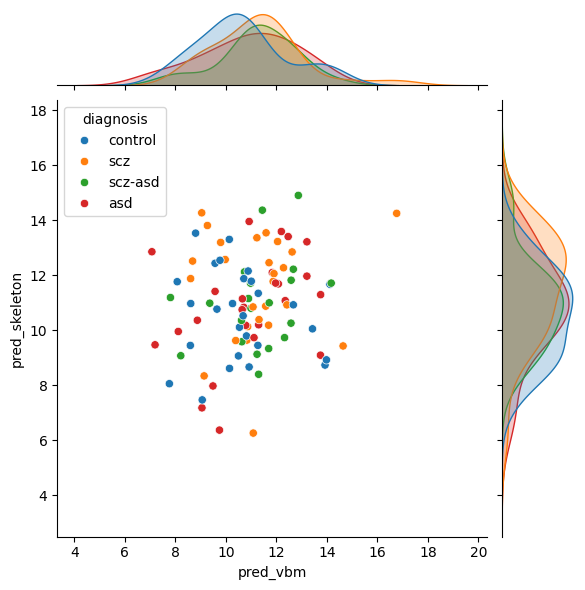

In [19]:
sns.jointplot(data=df_pred, x="pred_vbm", y="pred_skeleton", hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"))
plt.show()

In [20]:
print("ROC AUC")
for preproc in ["skeleton", "vbm"]:
    for diag_1, diag_2 in zip(["control", "control", "control", "scz", "scz", "scz-asd"],
                              ["scz", "scz-asd", "asd", "scz-asd", "asd", "asd"]):
        
        y_true = df_pred.loc[df_pred["diagnosis"].isin([diag_1, diag_2]), "diagnosis"].values
        y_score = df_pred.loc[df_pred["diagnosis"].isin([diag_1, diag_2]), f"pred_{preproc}"].values
        roc_auc = roc_auc_score(y_score=y_score, y_true=y_true)
        print(f"Preproc: {preproc} - {diag_1} VS {diag_2}: {roc_auc:.2f}")

ROC AUC
Preproc: skeleton - control VS scz: 0.68
Preproc: skeleton - control VS scz-asd: 0.56
Preproc: skeleton - control VS asd: 0.44
Preproc: skeleton - scz VS scz-asd: 0.38
Preproc: skeleton - scz VS asd: 0.61
Preproc: skeleton - scz-asd VS asd: 0.50
Preproc: vbm - control VS scz: 0.63
Preproc: vbm - control VS scz-asd: 0.66
Preproc: vbm - control VS asd: 0.44
Preproc: vbm - scz VS scz-asd: 0.53
Preproc: vbm - scz VS asd: 0.53
Preproc: vbm - scz-asd VS asd: 0.55


# Stacking

## Average

In [52]:
df_pred["pred_mean"] = df_pred[["pred_vbm", "pred_skeleton"]].mean(axis=1)

In [54]:
df_pred.head()

,participant_id,session,age,sex,diagnosis,NSS,fold,pred_vbm,pred_skeleton,pred_mean
0,LF130278,1,19.0,M,asd,15.0,1.0,10.715117,10.827379,10.771248
1,LA130256,1,22.0,M,control,5.5,6.0,7.766585,8.049792,7.908189
2,DC140291,1,20.0,M,scz,9.5,1.0,11.088033,6.253654,8.670843
3,CS130274,1,24.0,F,scz,16.0,3.0,9.272300,13.802340,11.537319
4,YR150471,1,19.0,M,control,11.5,4.0,9.575321,12.428489,11.001905


In [53]:
for preproc in ["vbm", "skeleton", "mean"]:
    r2 = r2_score(y_pred=df_pred[f"pred_{preproc}"].values, y_true=df_pred["NSS"].values)
    rmse = mean_squared_error(y_pred=df_pred[f"pred_{preproc}"].values, y_true=df_pred["NSS"].values, squared=False) 
    mae = mean_absolute_error(y_pred=df_pred[f"pred_{preproc}"].values, y_true=df_pred["NSS"].values)

    print(preproc, r2, rmse, mae)

vbm -0.0416694407311482 7.607614999714979 5.952047051215659
skeleton 0.008993627677403082 7.4203055327343135 5.859839940557674
mean 0.007167469123268044 7.427139201009389 5.822997141857536


## Predictions stacking

In [55]:
logs = defaultdict(list)
preproc = "stacking"
for fold in range(nb_folds):
    print(f"Fold: {fold}")
    
    # 1) Load data
    train_mask = scheme[f"fold{fold}"] == "train"
    X_train = df_pred.loc[train_mask, ["pred_vbm", "pred_skeleton"]].values.astype(np.float32)
    y_train = df.loc[train_mask, label].values.astype(np.float32)

    test_mask = scheme[f"fold{fold}"] == "test"
    X_test = df_pred.loc[test_mask, ["pred_vbm", "pred_skeleton"]].values.astype(np.float32)
    y_test = df.loc[test_mask, label].values.astype(np.float32)

    # 2) Training
    hyperparams = {'alpha': [1e-1, 1, 10, 10**2, 10**3]}
    model_cv = GridSearchCV(Ridge(fit_intercept=True, solver="auto"), hyperparams, 
                            refit=True, n_jobs=3, scoring="neg_mean_absolute_error", cv=3)
    
    model_cv.fit(X_train, y_train)
    best_score, best_params = model_cv.best_score_, model_cv.best_params_
    print(f"Model train - best score : {best_score:.2g} | best params : {best_params}")

    # 3) Testing
    y_pred_test = model_cv.predict(X_test)
    df_pred.loc[test_mask, f"pred_stack"] = y_pred_test
    r2 = model_cv.best_estimator_.score(X_test, y_test)
    rmse = mean_squared_error(y_pred=y_pred_test, y_true=y_test, squared=False) 
    mae = mean_absolute_error(y_pred=y_pred_test, y_true=y_test)

    # 4) Saving        
    for metric, value in zip(["r2", "rmse", "mae"], [r2, rmse, mae]):
        logs["fold"].append(fold)
        logs["preproc"].append(preproc)
        logs["alpha"].append(best_params["alpha"])
        logs["split"].append("test")
        logs["metric"].append(metric)
        logs["value"].append(value)

Fold: 0
Model train - best score : -6.3 | best params : {'alpha': 1000}
Fold: 1
Model train - best score : -5.9 | best params : {'alpha': 1000}
Fold: 2
Model train - best score : -5.6 | best params : {'alpha': 1000}
Fold: 3
Model train - best score : -6.1 | best params : {'alpha': 1000}
Fold: 4
Model train - best score : -6.3 | best params : {'alpha': 1000}
Fold: 5
Model train - best score : -5.9 | best params : {'alpha': 1000}
Fold: 6
Model train - best score : -6.3 | best params : {'alpha': 1000}
Fold: 7
Model train - best score : -5.8 | best params : {'alpha': 1000}
Fold: 8
Model train - best score : -5.9 | best params : {'alpha': 1000}
Fold: 9
Model train - best score : -6 | best params : {'alpha': 1000}


In [57]:
logs_df_stack = pd.DataFrame(logs)
logs_df_stack.groupby("metric").describe()

fold                                          alpha          ...  \
       count mean      std  min   25%  50%   75%  max count    mean  ...   
metric                                                               ...   
mae     10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  421.12  ...   
r2      10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  421.12  ...   
rmse    10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  421.12  ...   

                       value                                          \
           75%     max count      mean       std       min       25%   
metric                                                                 
mae     1000.0  1000.0  10.0  5.853954  1.610962  2.983667  5.177171   
r2      1000.0  1000.0  10.0 -0.254892  0.567500 -1.665131 -0.391867   
rmse    1000.0  1000.0  10.0  7.169876  2.120793  4.197075  6.069934   

                                       
             50%       75%        max  
metric                                 
mae     6.346539  6.772565   8.382091  
r2     -0.072072  0.069577   0.258201  
rmse    7.018880  8.129377  11.603355  

[3 rows x 24 columns]

## Input concatenation

In [59]:
logs = defaultdict(list)
preproc = "stacking"
for fold in range(nb_folds):
    print(f"Fold: {fold}")
    
    # 0) Load data
    train_mask = scheme[f"fold{fold}"] == "train"
    X_train_skel = input_skel[train_mask]
    X_train_vbm = input_vbm[train_mask]
    y_train = df.loc[train_mask, label].values.astype(np.float32)

    test_mask = scheme[f"fold{fold}"] == "test"
    X_test_skel = input_skel[test_mask]
    X_test_vbm = input_vbm[test_mask]
    y_test = df.loc[test_mask, label].values.astype(np.float32)

    # 1) Normalization : no normalization need with skeletons   
    scaler = StandardScaler
    ss = scaler().fit(X_train_vbm)
    X_train_vbm = ss.transform(X_train_vbm)
    X_test_vbm = ss.transform(X_test_vbm)

    X_train = np.concatenate((X_train_vbm, X_train_skel), axis=1)
    X_test = np.concatenate((X_test_vbm, X_test_skel), axis=1)

    print(X_train_vbm.shape, X_train_skel.shape)
    print(X_test_vbm.shape, X_test_skel.shape)
    print(X_train.shape, X_test.shape)

    # 2) Training
    hyperparams = {'alpha': [1e-1, 1, 10, 10**2, 10**3]}
    model_cv = GridSearchCV(Ridge(fit_intercept=True, solver="auto"), hyperparams, 
                            refit=True, n_jobs=3, scoring="neg_mean_absolute_error", cv=3)
    
    model_cv.fit(X_train, y_train)
    best_score, best_params = model_cv.best_score_, model_cv.best_params_
    print(f"Model train - best score : {best_score:.2g} | best params : {best_params}")

    # 3) Testing
    y_pred_test = model_cv.predict(X_test)
    df_pred.loc[test_mask, f"pred_concat"] = y_pred_test
    r2 = model_cv.best_estimator_.score(X_test, y_test)
    rmse = mean_squared_error(y_pred=y_pred_test, y_true=y_test, squared=False) 
    mae = mean_absolute_error(y_pred=y_pred_test, y_true=y_test)

    # 4) Saving        
    for metric, value in zip(["r2", "rmse", "mae"], [r2, rmse, mae]):
        logs["fold"].append(fold)
        logs["preproc"].append(preproc)
        logs["alpha"].append(best_params["alpha"])
        logs["split"].append("test")
        logs["metric"].append(metric)
        logs["value"].append(value)

Fold: 0
(88, 331695) (88, 547964)
(10, 331695) (10, 547964)
(88, 879659) (10, 879659)


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -6.2 | best params : {'alpha': 100}
Fold: 1
(88, 331695) (88, 547964)
(10, 331695) (10, 547964)
(88, 879659) (10, 879659)


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -5.6 | best params : {'alpha': 1}
Fold: 2
(89, 331695) (89, 547964)
(9, 331695) (9, 547964)
(89, 879659) (9, 879659)


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -5.7 | best params : {'alpha': 1000}
Fold: 3
(88, 331695) (88, 547964)
(10, 331695) (10, 547964)
(88, 879659) (10, 879659)


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -6.1 | best params : {'alpha': 10}
Fold: 4
(88, 331695) (88, 547964)
(10, 331695) (10, 547964)
(88, 879659) (10, 879659)


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=1.67055e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in s

Model train - best score : -6.1 | best params : {'alpha': 0.1}
Fold: 5
(88, 331695) (88, 547964)
(10, 331695) (10, 547964)
(88, 879659) (10, 879659)


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -5.9 | best params : {'alpha': 1000}
Fold: 6
(89, 331695) (89, 547964)
(9, 331695) (9, 547964)
(89, 879659) (9, 879659)


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -6.2 | best params : {'alpha': 1000}
Fold: 7
(88, 331695) (88, 547964)
(10, 331695) (10, 547964)
(88, 879659) (10, 879659)


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -5.8 | best params : {'alpha': 0.1}
Fold: 8
(88, 331695) (88, 547964)
(10, 331695) (10, 547964)
(88, 879659) (10, 879659)


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -6.1 | best params : {'alpha': 1000}
Fold: 9
(88, 331695) (88, 547964)
(10, 331695) (10, 547964)
(88, 879659) (10, 879659)


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Model train - best score : -6 | best params : {'alpha': 100}


In [48]:
logs_df_concat = pd.DataFrame(logs)
logs_df_concat.groupby("metric").describe()

fold                                          alpha          ...  \
       count mean      std  min   25%  50%   75%  max count    mean  ...   
metric                                                               ...   
mae     10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  421.12  ...   
r2      10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  421.12  ...   
rmse    10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  421.12  ...   

                       value                                          \
           75%     max count      mean       std       min       25%   
metric                                                                 
mae     1000.0  1000.0  10.0  5.853954  1.610962  2.983667  5.177171   
r2      1000.0  1000.0  10.0 -0.254892  0.567500 -1.665131 -0.391867   
rmse    1000.0  1000.0  10.0  7.169876  2.120793  4.197075  6.069934   

                                       
             50%       75%        max  
metric                                 
mae     6.346539  6.772565   8.382091  
r2     -0.072072  0.069577   0.258201  
rmse    7.018880  8.129377  11.603355  

[3 rows x 24 columns]

## Plots

In [67]:
data = defaultdict(list)
for fold in range(nb_folds):
    for pred in ["pred_skeleton", "pred_vbm", "pred_mean", "pred_stack", "pred_concat"]:
        data["prediction"].append(pred.split("_")[1])
        data["r2"].append(r2_score(y_true=df_pred.loc[df_pred["fold"] == fold, "NSS"].values, y_pred=df_pred.loc[df_pred["fold"] == fold, pred].values))
        data["rmse"].append(mean_squared_error(y_true=df_pred.loc[df_pred["fold"] == fold, "NSS"].values, y_pred=df_pred.loc[df_pred["fold"] == fold, pred].values, squared=False))
        data["mae"].append(mean_absolute_error(y_true=df_pred.loc[df_pred["fold"] == fold, "NSS"].values, y_pred=df_pred.loc[df_pred["fold"] == fold, pred].values))
scores_df = pd.DataFrame(data)

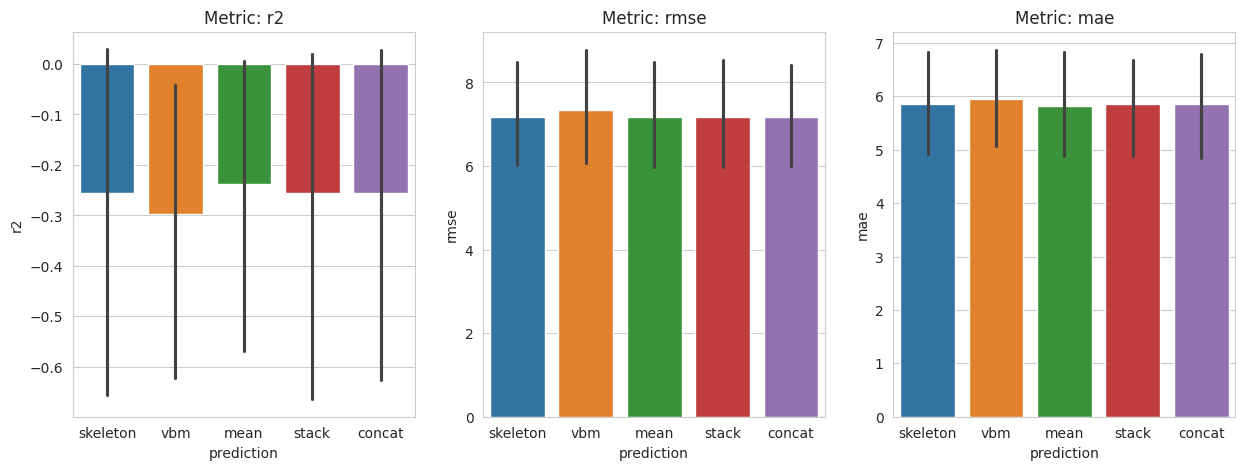

In [70]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(5*3, 5*1))

    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=scores_df, x="prediction", y=metric, hue="prediction", ax=ax[i])
        ax[i].set_title(f"Metric: {metric}")
plt.show()

In [ ]:

logs_df_full = pd.concat((logs_df, logs_df_stack, logs_df_concat), axis=0)

# Predictions of other metadata

In [24]:
path_to_models = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models"
saving_dir = os.path.join(path_to_models, "vbm", "20240905_all_predictions")
df_pred_metadata_vbm = pd.read_csv(os.path.join(saving_dir, "vbm_all_predictions.csv"))

saving_dir = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models/skeleton/20240903_ridge_with_smoothing"
df_pred_metadata_skel = pd.read_csv(os.path.join(saving_dir, "skeleton_all_predictions.csv"))

df_pred_metadata = pd.concat((df_pred_metadata_vbm, df_pred_metadata_skel), axis=0, ignore_index=True)
df_pred_metadata["preproc"] = ["vbm" for _ in range(len(df_pred_metadata_vbm))] + ["skeleton" for _ in range(len(df_pred_metadata_skel))]

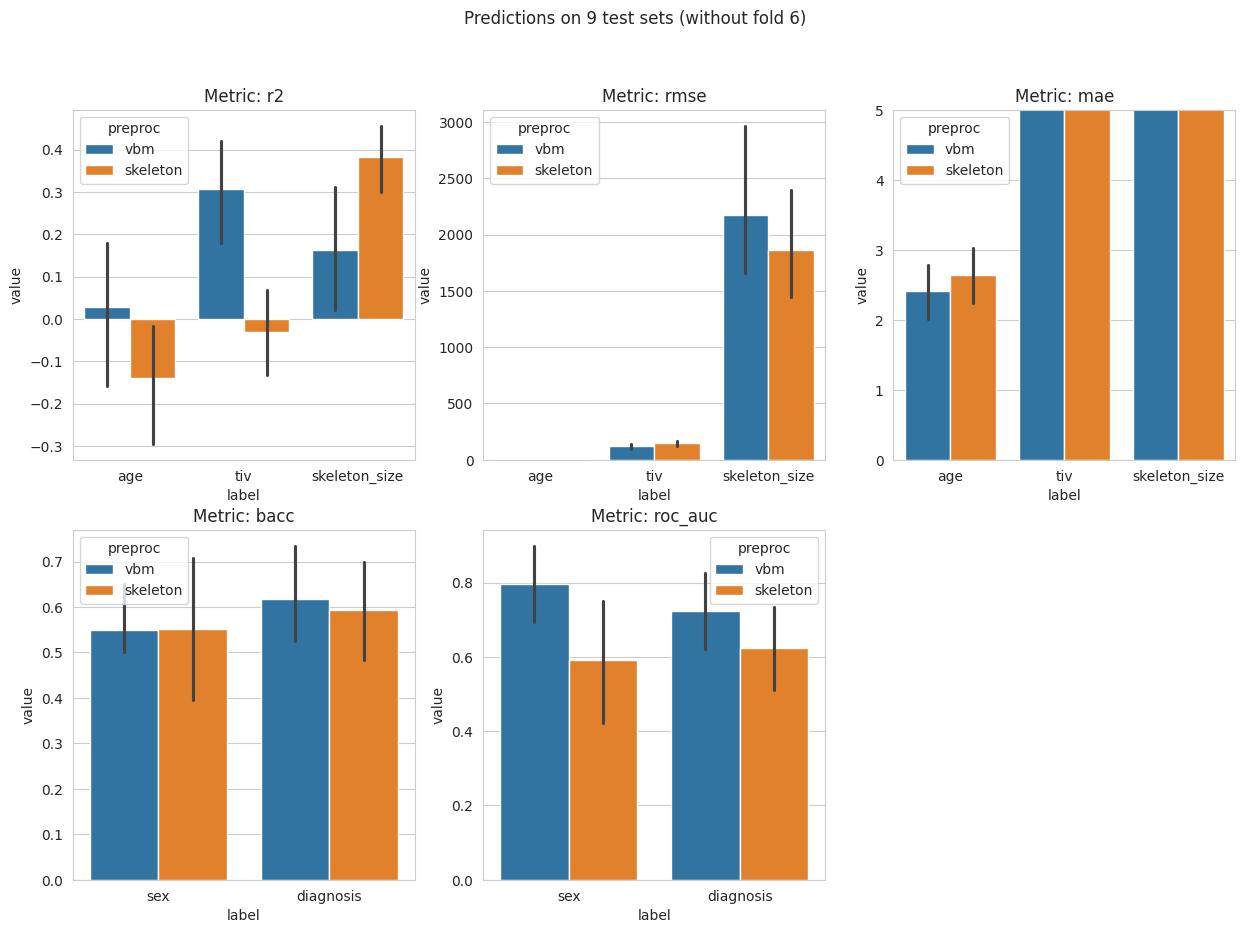

In [25]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(2, 3, figsize=(5*3, 5*2))

    fig.suptitle("Predictions on 9 test sets (without fold 6)")
    
    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=df_pred_metadata[(df_pred_metadata["metric"] == metric) & (df_pred_metadata["fold"] != 6) & (df_pred_metadata["split"] == "test")], 
                    x="label", y="value", hue="preproc", ax=ax[0, i])
        ax[0, i].set_title(f"Metric: {metric}")
    ax[0, 2].set(ylim=(0, 5))

    for i, metric in enumerate(["bacc", "roc_auc"]):
        sns.barplot(data=df_pred_metadata[(df_pred_metadata["metric"] == metric) & (df_pred_metadata["split"] == "test")], 
                    x="label", y="value", hue="preproc", ax=ax[1, i])
        ax[1, i].set_title(f"Metric: {metric}")
    ax[1, 2].set_axis_off()

    plt.show()

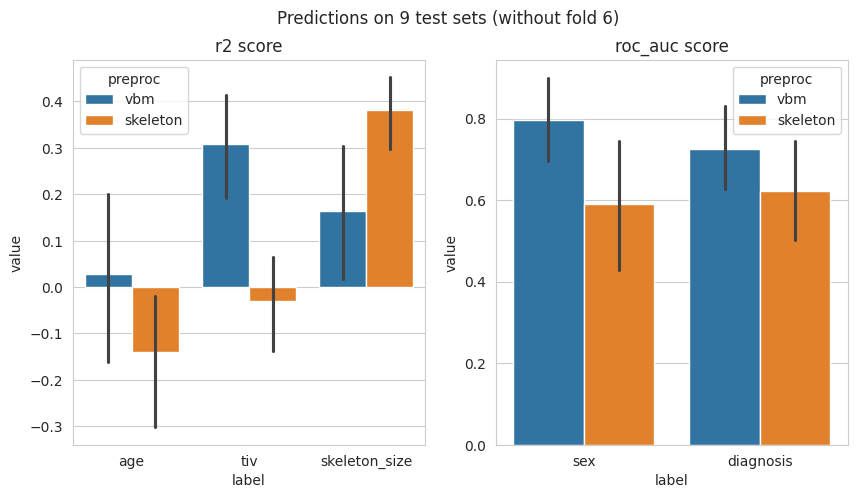

In [26]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 2, figsize=(5*2, 5*1))

    fig.suptitle("Predictions on 9 test sets (without fold 6)")
    
    metric = "r2"
    sns.barplot(data=df_pred_metadata[(df_pred_metadata["metric"] == metric) & (df_pred_metadata["fold"] != 6) & (df_pred_metadata["split"] == "test")], 
                x="label", y="value", hue="preproc", ax=ax[0])
    ax[0].set_title(f"{metric} score")

    metric = "roc_auc"
    sns.barplot(data=df_pred_metadata[(df_pred_metadata["metric"] == metric) & (df_pred_metadata["split"] == "test")], 
                x="label", y="value", hue="preproc", ax=ax[1])
    ax[1].set_title(f"{metric} score")

    plt.show()

In [41]:
# For the diapo
# /!\ logs df est mal défini ! 
logs_df["label"] = "NSS"
logs_df = logs_df.drop("alpha", axis=1)


df_diapo = pd.concat([df_pred_metadata[(df_pred_metadata["metric"].isin(["roc_auc", "r2"])) & (df_pred_metadata["split"] == "test")], 
                      logs_df[(logs_df["metric"] == "r2") & (logs_df["split"] == "test")]], axis=0)

In [42]:
df_diapo

,label,fold,split,metric,value,preproc
2,sex,0,test,roc_auc,0.875000,vbm
9,sex,2,test,roc_auc,0.625000,vbm
13,sex,3,test,roc_auc,0.555556,vbm
17,sex,4,test,roc_auc,0.888889,vbm
21,sex,5,test,roc_auc,0.812500,vbm
...,...,...,...,...,...,...
45,NSS,7,test,r2,0.069139,skeleton
48,NSS,8,test,r2,-0.333862,vbm
51,NSS,8,test,r2,-0.098418,skeleton
54,NSS,9,test,r2,-1.556687,vbm


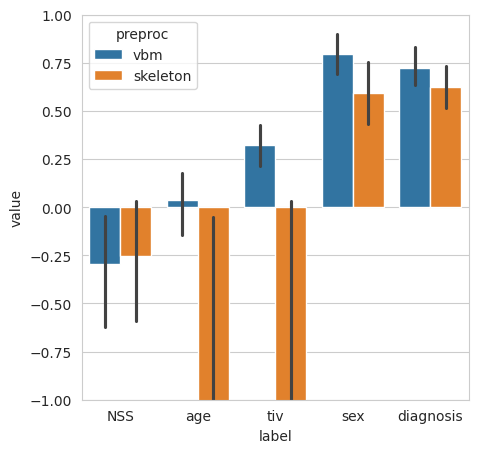

In [51]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(5*1, 5*1))
    sns.barplot(data=df_diapo[df_diapo["label"] != "skeleton_size"], x="label", order=("NSS", "age", "tiv", "sex", "diagnosis"), y="value", hue="preproc", ax=ax)
    ax.set_ylim(-1, 1)
plt.show()

# New stratification on NSS scores, sex and age

## Predictions of metadata (sex, age, diagnosis)

In [3]:
path_to_models = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models"
labels = ["age", "tiv", "sex", "diagnosis"]
models = ["logreg" if l in ["sex", "diagnosis"] else "lrl2" for l in labels]

saving_dir = os.path.join(path_to_models, "vbm", "20240927_nss_sex_age_stratification")
df_pred_metadata_vbm = pd.concat([pd.read_csv(os.path.join(saving_dir, f"preproc-vbm_model-{m}_label-{l}.csv")) for l, m in zip(labels, models)], axis=0)

saving_dir = os.path.join(path_to_models, "skeleton", "20241001_nss_sex_age_stratification_no_scaler")
df_pred_metadata_skel = pd.concat([pd.read_csv(os.path.join(saving_dir, f"preproc-skeleton_model-{m}_label-{l}.csv")) for l, m in zip(labels, models)], axis=0)

df_pred_metadata = pd.concat((df_pred_metadata_vbm, df_pred_metadata_skel), axis=0, ignore_index=True)

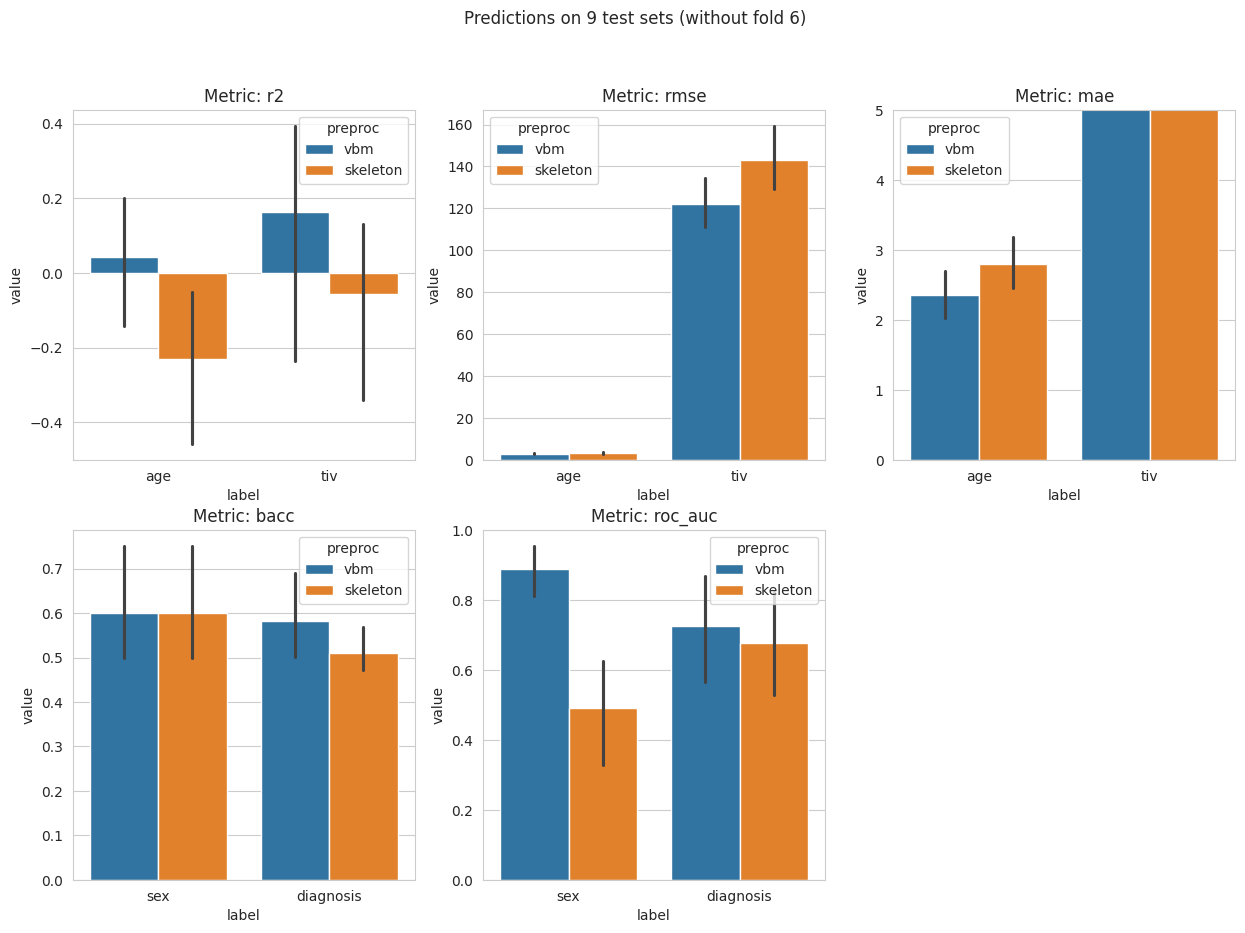

In [4]:
# /!\ Some metrics do not have the score on all the folds
# (for instance, some test sets do not have F, so models do not hace a ROC AUC for this test set)

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(2, 3, figsize=(5*3, 5*2))

    fig.suptitle("/")
    
    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=df_pred_metadata[(df_pred_metadata["metric"] == metric) & (df_pred_metadata["split"] == "test")], 
                    x="label", y="value", hue="preproc", ax=ax[0, i])
        ax[0, i].set_title(f"Metric: {metric}")
    ax[0, 2].set(ylim=(0, 5))

    for i, metric in enumerate(["bacc", "roc_auc"]):
        sns.barplot(data=df_pred_metadata[(df_pred_metadata["metric"] == metric) & (df_pred_metadata["split"] == "test")], 
                    x="label", y="value", hue="preproc", ax=ax[1, i])
        ax[1, i].set_title(f"Metric: {metric}")
    ax[1, 2].set_axis_off()

    plt.show()

## NSS predictions

In [37]:
id_types = {"participant_id": str,
            "session": int,
            "acq": int,
            "run": int}
root = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/without_nss_scores_from_tableau/processed"
scheme = pd.read_csv(os.path.join(root, "nss_sex_age_stratified_10_fold_ausz.csv"), dtype=id_types)
df = pd.read_csv(os.path.join(root, "ausz_t1mri_participants.csv"), dtype=id_types)

assert (df[["participant_id", "session"]] == scheme[["participant_id", "session"]]).all().all()

In [39]:
df_pred = df[["participant_id", "NSS", "diagnosis", "sex", "age"]].copy(deep=True)

path_to_models = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models"
label = "NSS"
nb_folds = 10

for fold in range(nb_folds):
    df_pred.loc[scheme[f"fold{fold}"] == "test", "fold"] = fold
    # VBM
    saving_dir = os.path.join(path_to_models, "vbm", "20240927_nss_sex_age_stratification")
    df_pred.loc[scheme[f"fold{fold}"] == "test", "NSS_pred_vbm"] = np.load(os.path.join(saving_dir, f"y_pred_label-{label}_preproc-vbm_fold-{fold}.npy"))
    # Skeleton
    saving_dir = os.path.join(path_to_models, "skeleton", "20241001_nss_sex_age_stratification_no_scaler")
    df_pred.loc[scheme[f"fold{fold}"] == "test", "NSS_pred_skeleton"] = np.load(os.path.join(saving_dir, f"y_pred_label-{label}_preproc-skeleton_fold-{fold}.npy"))

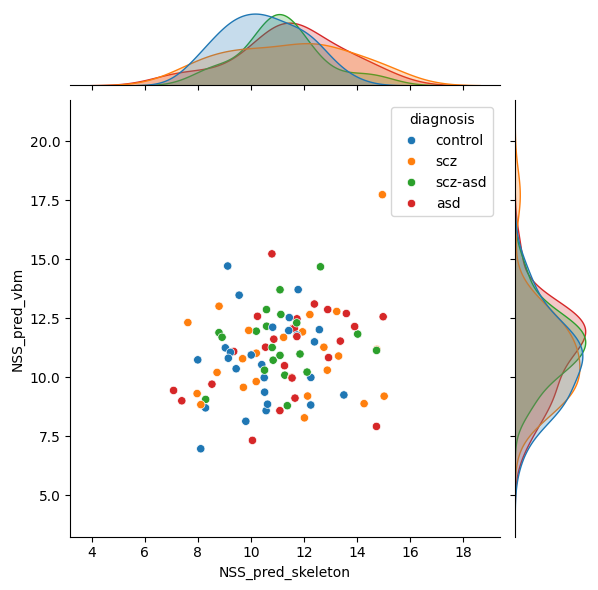

In [40]:
sns.jointplot(data=df_pred, x="NSS_pred_skeleton", y="NSS_pred_vbm", hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"))
plt.show()

## Stacking

In [21]:
id_types = {"participant_id": str,
            "session": int,
            "acq": int,
            "run": int}
root = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/without_nss_scores_from_tableau/processed"
scheme = pd.read_csv(os.path.join(root, "nss_sex_age_stratified_10_fold_ausz.csv"), dtype=id_types)
df = pd.read_csv(os.path.join(root, "ausz_t1mri_participants.csv"), dtype=id_types)

assert (df[["participant_id", "session"]] == scheme[["participant_id", "session"]]).all().all()

In [22]:
df_pred = df[["participant_id", "NSS"]].copy(deep=True)

path_to_models = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models"
label = "NSS"
nb_folds = 10

for fold in range(nb_folds):
    df_pred.loc[scheme[f"fold{fold}"] == "test", "fold"] = fold
    # VBM
    saving_dir = os.path.join(path_to_models, "vbm", "20240927_nss_sex_age_stratification")
    df_pred.loc[scheme[f"fold{fold}"] == "test", "y_pred_vbm"] = np.load(os.path.join(saving_dir, f"y_pred_label-{label}_preproc-vbm_fold-{fold}.npy"))
    # Skeleton
    saving_dir = os.path.join(path_to_models, "skeleton", "20241001_nss_sex_age_stratification_no_scaler")
    df_pred.loc[scheme[f"fold{fold}"] == "test", "y_pred_skeleton"] = np.load(os.path.join(saving_dir, f"y_pred_label-{label}_preproc-skeleton_fold-{fold}.npy"))

### Average of predictions

In [23]:
df_pred["y_pred_mean"] = df_pred[["y_pred_vbm", "y_pred_skeleton"]].mean(axis=1)

In [24]:
df_pred.head()

,participant_id,NSS,fold,y_pred_vbm,y_pred_skeleton,y_pred_mean
0,LF130278,15.0,6.0,12.077148,11.590117,11.833633
1,LA130256,5.5,5.0,6.966332,8.112391,7.539361
2,DC140291,9.5,2.0,12.318145,7.626998,9.972571
3,CS130274,16.0,4.0,8.879926,14.263639,11.571783
4,YR150471,11.5,3.0,9.988679,12.258789,11.123734


### Predictions stacking

In [25]:
logs = defaultdict(list)
preproc = "stacking"
for fold in range(nb_folds):
    print(f"Fold: {fold}")
    
    # 1) Load data
    train_mask = scheme[f"fold{fold}"] == "train"
    X_train = df_pred.loc[train_mask, ["y_pred_vbm", "y_pred_skeleton"]].values.astype(np.float32)
    y_train = df.loc[train_mask, label].values.astype(np.float32)

    test_mask = scheme[f"fold{fold}"] == "test"
    X_test = df_pred.loc[test_mask, ["y_pred_vbm", "y_pred_skeleton"]].values.astype(np.float32)
    y_test = df.loc[test_mask, label].values.astype(np.float32)

    # 2) Training
    hyperparams = {'alpha': [1e-1, 1, 10, 10**2, 10**3]}
    model_cv = GridSearchCV(Ridge(fit_intercept=True, solver="auto"), hyperparams, 
                            refit=True, n_jobs=3, scoring="neg_mean_absolute_error", cv=3)
    
    model_cv.fit(X_train, y_train)
    best_score, best_params = model_cv.best_score_, model_cv.best_params_
    print(f"Model train - best score : {best_score:.2g} | best params : {best_params}")

    # 3) Testing
    y_pred_test = model_cv.predict(X_test)
    df_pred.loc[test_mask, f"y_pred_stack"] = y_pred_test
    r2 = model_cv.best_estimator_.score(X_test, y_test)
    rmse = mean_squared_error(y_pred=y_pred_test, y_true=y_test, squared=False) 
    mae = mean_absolute_error(y_pred=y_pred_test, y_true=y_test)

    # 4) Saving        
    for metric, value in zip(["r2", "rmse", "mae"], [r2, rmse, mae]):
        logs["fold"].append(fold)
        logs["preproc"].append(preproc)
        logs["alpha"].append(best_params["alpha"])
        logs["split"].append("test")
        logs["metric"].append(metric)
        logs["value"].append(value)

Fold: 0
Model train - best score : -5.7 | best params : {'alpha': 100}
Fold: 1
Model train - best score : -5.9 | best params : {'alpha': 100}
Fold: 2
Model train - best score : -5.9 | best params : {'alpha': 10}
Fold: 3
Model train - best score : -6 | best params : {'alpha': 10}
Fold: 4
Model train - best score : -6 | best params : {'alpha': 100}
Fold: 5
Model train - best score : -5.7 | best params : {'alpha': 1000}
Fold: 6
Model train - best score : -6.1 | best params : {'alpha': 10}
Fold: 7
Model train - best score : -6.2 | best params : {'alpha': 100}
Fold: 8
Model train - best score : -5.5 | best params : {'alpha': 10}
Fold: 9
Model train - best score : -6.2 | best params : {'alpha': 100}


In [26]:
logs_df_stack = pd.DataFrame(logs)
logs_df_stack.groupby("metric").describe()

fold                                          alpha         ...  \
       count mean      std  min   25%  50%   75%  max count   mean  ...   
metric                                                              ...   
mae     10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  154.0  ...   
r2      10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  154.0  ...   
rmse    10.0  4.5  3.02765  0.0  2.25  4.5  6.75  9.0  10.0  154.0  ...   

                      value                                                    \
          75%     max count      mean       std       min       25%       50%   
metric                                                                          
mae     100.0  1000.0  10.0  6.153855  1.611940  4.274275  4.716511  5.901560   
r2      100.0  1000.0  10.0 -0.203161  0.282095 -0.807687 -0.285920 -0.154728   
rmse    100.0  1000.0  10.0  7.512227  2.264608  5.038268  5.633465  7.591097   

                             
             75%        max  
metric                       
mae     7.242741   8.886156  
r2      0.002177   0.106821  
rmse    8.408463  12.336555  

[3 rows x 24 columns]

### Plot

In [27]:
data = defaultdict(list)
for fold in range(nb_folds):
    for pred in ["y_pred_skeleton", "y_pred_vbm", "y_pred_mean", "y_pred_stack"]:
        data["prediction"].append(pred.split("_")[2])
        data["r2"].append(r2_score(y_true=df_pred.loc[df_pred["fold"] == fold, "NSS"].values, y_pred=df_pred.loc[df_pred["fold"] == fold, pred].values))
        data["rmse"].append(mean_squared_error(y_true=df_pred.loc[df_pred["fold"] == fold, "NSS"].values, y_pred=df_pred.loc[df_pred["fold"] == fold, pred].values, squared=False))
        data["mae"].append(mean_absolute_error(y_true=df_pred.loc[df_pred["fold"] == fold, "NSS"].values, y_pred=df_pred.loc[df_pred["fold"] == fold, pred].values))
scores_df = pd.DataFrame(data)

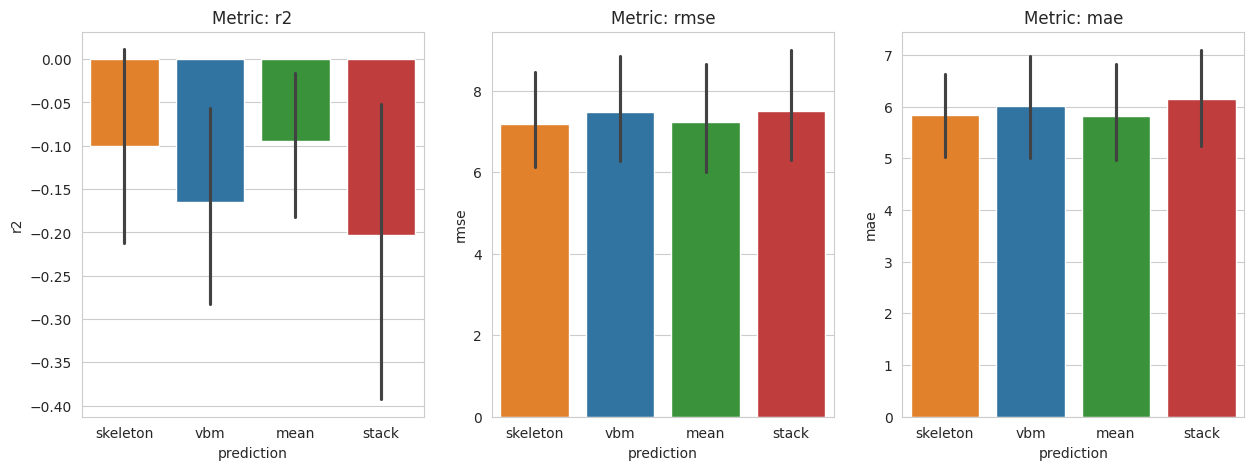

In [30]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(5*3, 5*1))

    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=scores_df, x="prediction", y=metric, hue="prediction", hue_order=("vbm", "skeleton", "mean", "stack"), ax=ax[i])
        ax[i].set_title(f"Metric: {metric}")
plt.show()

# Only NSS scores for stratification

## NSS score predictions

In [2]:
def pivot_df(df):
    df = df[df["split"] == "test"]
    split = "test"
    model = df["model"].iloc[0]
    assert (df["model"] == model).all()
    preproc = df["preproc"].iloc[0]
    assert (df["preproc"] == preproc).all()
    label =  df["label"].iloc[0]
    assert (df["label"] == label).all()
    df = df.pivot(index="fold", columns="metric", values="value")
    df = df.rename_axis(None, axis=1)
    df = df.reset_index()
    df = df.rename(columns={"mae": "mean_absolute_error", "rmse": "root_mean_squarred_error"})
    df["set"] = split
    df["preproc"] = preproc
    df["model"] = model
    df["label"] = label
    return df

In [3]:
# Data Loading
path2models = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models"
# VBM
df_vbm_ml = pd.read_csv(os.path.join(path2models, "vbm", "20241007_nss_stratification", f"preproc-vbm_model-lrl2_label-NSS.csv"), sep=",")
df_vbm_ml = pivot_df(df_vbm_ml)
df_vbm_ml["method"] = "vbm_sml"
df_vbm_dl = pd.concat([pd.read_csv(os.path.join(path2models, "vbm", "20241007_dlmodel-vbm", f"dlmodel_fold-{fold}_epoch-99_test.csv")) for fold in range(10)] , axis=0)
df_vbm_dl["method"] = "vbm_dl"
df_vbm_dl["model"] = "resnet18"
df_vbm_dl["label"] = "NSS"
df_vbm_dl["preproc"] = "vbm"
# Skeleton
df_skel_ml = pd.read_csv(os.path.join(path2models, "skeleton", "20241007_nss_stratification", f"preproc-skeleton_model-lrl2_label-NSS.csv"), sep=",")
df_skel_ml = pivot_df(df_skel_ml)
df_skel_ml["method"] = "skeleton_sml"
df_skel_dl = pd.concat([pd.read_csv(os.path.join(path2models, "skeleton", "20241007_dlmodel-skeleton", f"dlmodel_fold-{fold}_epoch-99_test.csv")) for fold in range(10)], axis=0)
df_skel_dl["method"] = "skeleton_dl"
df_skel_dl["model"] = "resnet18"
df_skel_dl["label"] = "NSS"
df_skel_dl["preproc"] = "skeleton"
# Freesurfer
df_area_ml = pd.read_csv(os.path.join(path2models, "freesurfer", "20241007_nss_stratification", f"texture-area_model-lrl2_label-NSS.csv"))
df_area_ml["model"] = "lrl2"
df_area_ml["preproc"] = "freesurfer"
df_area_ml = pivot_df(df_area_ml)
df_area_ml["method"] = "area"
df_curv_ml = pd.read_csv(os.path.join(path2models, "freesurfer", "20241007_nss_stratification", f"texture-curv_model-lrl2_label-NSS.csv"))
df_curv_ml["model"] = "lrl2"
df_curv_ml["preproc"] = "freesurfer"
df_curv_ml = pivot_df(df_curv_ml)
df_curv_ml["method"] = "curv"
df_thickness_ml = pd.read_csv(os.path.join(path2models, "freesurfer", "20241007_nss_stratification", f"texture-thickness_model-lrl2_label-NSS.csv"))
df_thickness_ml["model"] = "lrl2"
df_thickness_ml["preproc"] = "freesurfer"
df_thickness_ml = pivot_df(df_thickness_ml)
df_thickness_ml["method"] = "cortical_thickness"
df_nss_predictions = pd.concat((df_vbm_ml, df_vbm_dl, df_skel_ml, df_skel_dl, df_area_ml, df_curv_ml, df_thickness_ml), axis=0, ignore_index=True)

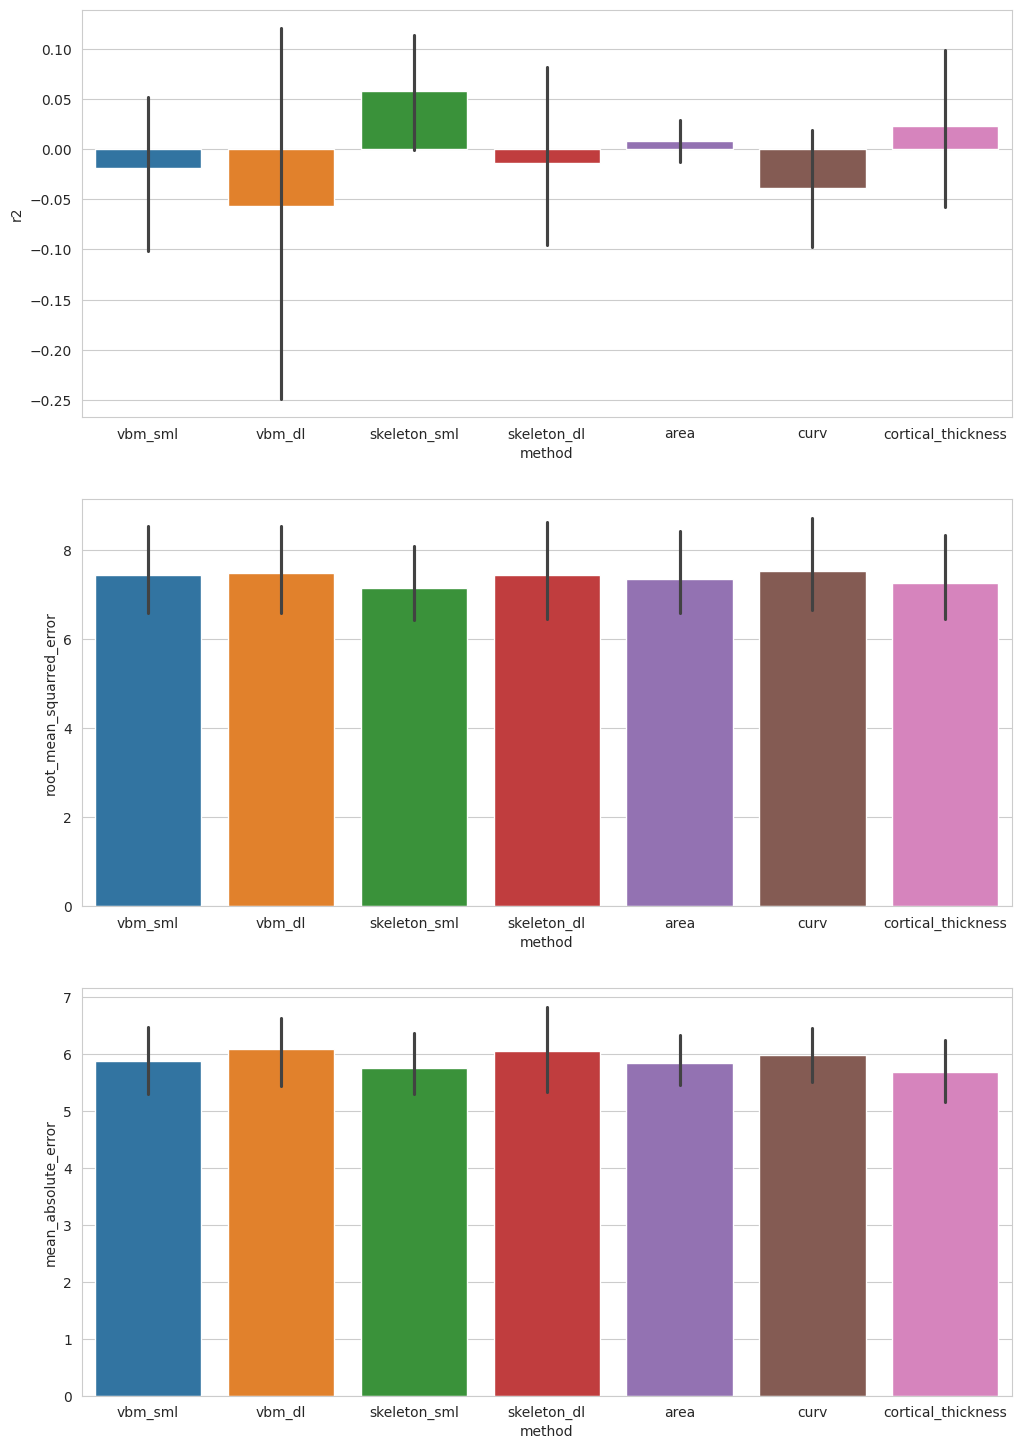

In [4]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(3, 1, figsize=(12, 3*6))
    for i, metric in enumerate(["r2", "root_mean_squarred_error", "mean_absolute_error"]):
        sns.barplot(data=df_nss_predictions, x="method", y=metric, hue="method", ax=ax[i])
plt.show()

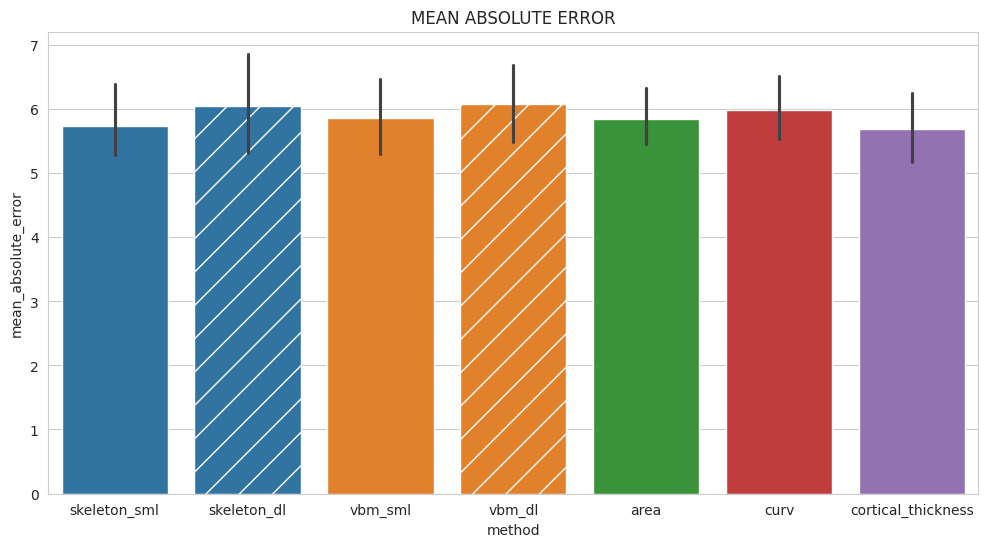

In [9]:
with sns.axes_style("whitegrid"):
    order = ("skeleton_sml", "skeleton_dl", "vbm_sml", "vbm_dl", "area", "curv", "cortical_thickness")
    palette = [sns.color_palette()[0], sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[1]] + \
              [sns.color_palette()[i] for i in range(2, (len(order)-2))]
    fig, ax = plt.subplots(1, 1, figsize=(12, 1*6))
    bar = sns.barplot(data=df_nss_predictions, x="method", y="mean_absolute_error", hue="method", 
                      order=order, hue_order=order, palette=palette, ax=ax)
    bar.patches[1].set_hatch("/")
    bar.patches[3].set_hatch("/")
    ax.set_title("MEAN ABSOLUTE ERROR")
plt.show()

In [10]:
df_nss_predictions[["method", "r2", "mean_absolute_error", "root_mean_squarred_error"]].groupby("method").describe(percentiles=[0.5])

r2                                                    \
                   count      mean       std       min       50%       max   
method                                                                       
area                10.0  0.008450  0.036739 -0.047854  0.007988  0.053896   
cortical_thickness  10.0  0.022758  0.139067 -0.259287  0.058237  0.165499   
curv                10.0 -0.039154  0.101529 -0.200684 -0.041129  0.119133   
skeleton_dl         10.0 -0.014250  0.151172 -0.182934 -0.075900  0.262839   
skeleton_sml        10.0  0.057677  0.098674 -0.126055  0.062263  0.200263   
vbm_dl              10.0 -0.057013  0.302933 -0.691184  0.016528  0.354413   
vbm_sml             10.0 -0.018861  0.133930 -0.281398  0.001170  0.119689   

                   mean_absolute_error                                \
                                 count      mean       std       min   
method                                                                 
area                              10.0  5.836740  0.740087  5.167892   
cortical_thickness                10.0  5.685060  0.930336  4.214799   
curv                              10.0  5.976896  0.888063  5.022553   
skeleton_dl                       10.0  6.051216  1.230705  4.408320   
skeleton_sml                      10.0  5.740329  0.915873  4.949099   
vbm_dl                            10.0  6.073671  1.027836  4.216030   
vbm_sml                           10.0  5.863165  1.010283  4.417838   

                                       root_mean_squarred_error            \
                         50%       max                    count      mean   
method                                                                      
area                5.603008  7.330269                     10.0  7.351627   
cortical_thickness  5.553961  7.193073                     10.0  7.269950   
curv                5.856558  7.861896                     10.0  7.526626   
skeleton_dl         5.757372  8.363758                     10.0  7.444289   
skeleton_sml        5.677261  7.943972                     10.0  7.137735   
vbm_dl              5.944882  7.591715                     10.0  7.478363   
vbm_sml             5.865971  7.619876                     10.0  7.440953   

                                                             
                         std       min       50%        max  
method                                                       
area                1.640685  6.076128  6.639412  11.403646  
cortical_thickness  1.572012  5.715591  6.803705  10.782977  
curv                1.764300  5.921340  6.798106  11.911862  
skeleton_dl         1.870988  5.269094  7.046147  11.704317  
skeleton_sml        1.526914  5.854827  6.607548  11.078812  
vbm_dl              1.696543  5.699171  7.016036  11.173664  
vbm_sml             1.717422  5.877786  6.953375  11.526318